In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

from nonlinear import initial_distribution, transition_model, observation_model
from filters import bootstrap_pf, log_likelihood

save_figures = False

#### b.4

In [3]:
def particle_metropolis_hastings(y, n_iters, n_particles, p_theta, q, init_dist, tr_model, obs_model):
    """
    Performs Particle Metropolis-Hastings sampling for Bayesian parameter estimation.

    :param y:           observations
    :param n_iters:     number of iterations for the Metropolis-Hastings algorithm
    :param n_particles: number of particles for the bootstrap particle filter
    :param p_theta :    prior distribution of the parameters
    :param q:           proposal distribution function for Metropolis-Hastings;
                        takes the current parameter value and returns a distribution object
    :param init_dist:   function defining the initial state distribution;
                        takes the proposed parameter values as input
    :param obs_model:   observation model function relating states to observations;
                        takes the proposed parameter values as input

    :return: sampled parameter values
    """
    theta0 = p_theta.rvs()
    while (theta0 > 1e4).any():
        theta0 = p_theta.rvs()
    theta = np.zeros((n_iters + 1, len(theta0)))
    theta[0] = theta0

    log_ls = np.zeros((n_iters + 1,))

    uniform_rvs = stats.uniform.rvs(size=n_iters)
    for k in range(n_iters + 1):
        if k == 0:
            theta_candidate = theta0
        else:
            theta_candidate = q(theta[k - 1]).rvs()

        p0 = init_dist(theta_candidate)
        p = tr_model(theta_candidate)
        nu = obs_model(theta_candidate)

        u, _, _ = bootstrap_pf(y, n_particles, p0, p, nu)
        log_l = log_likelihood(u, y, nu)

        if k == 0:
            log_ls[0] = log_l
            continue

        alpha = (
                 p_theta.pdf(theta_candidate) / p_theta.pdf(theta[k - 1]) *
                 np.exp(log_l - log_ls[k - 1]) *
                 q(theta_candidate).pdf(theta[k - 1]) / q(theta[k - 1]).pdf(theta_candidate)
        ).prod()
        alpha = min(1, alpha)

        if uniform_rvs[k - 1] < alpha:
            theta[k] = theta_candidate
            log_ls[k] = log_l
        else:
            theta[k] = theta[k - 1]
            log_ls[k] = log_ls[k - 1]

    return theta

In [2]:
# Data
phi = 0.985

In [ ]:
np.random.seed(566)
y = pd.read_csv('synthetic_data.csv')['y'].array
y = y.insert(0, 0.)

In [4]:
n_iters = 400
n_particles = 2 ** 6
p_theta = stats.invgamma([0.01, 0.01], scale=[0.01, 0.01])
q = lambda th: stats.truncnorm(-th/5, np.inf, loc=th, scale=5)
init_dist = lambda th: initial_distribution(phi, th[0])
tr_model = lambda th: transition_model(phi, th[0])
obs_model = lambda th: observation_model(th[1])

theta = particle_metropolis_hastings(y, n_iters, n_particles, p_theta, q, init_dist, tr_model, obs_model)

/home/rina/miniconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:4647: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / sc.gammainccinv(a, q)


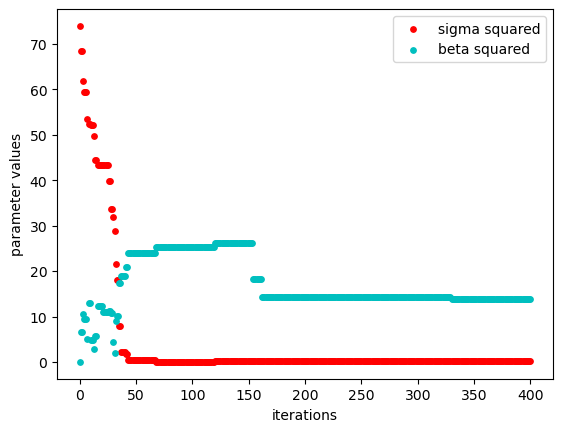

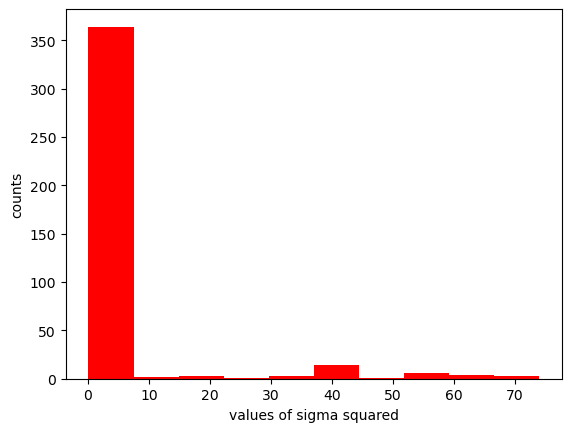

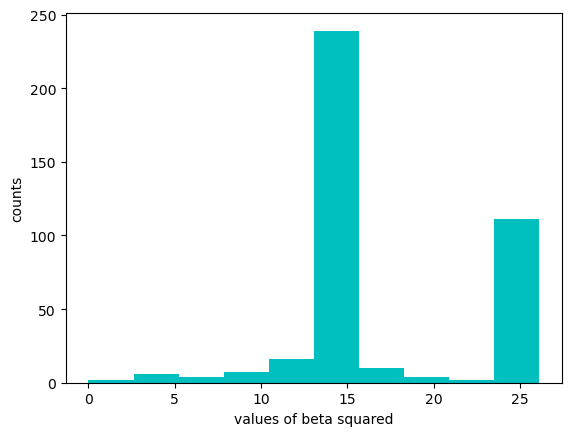

In [7]:
plt.scatter(np.arange(n_iters + 1), theta[:, 0], label="sigma squared", c='r', s=15)
plt.scatter(np.arange(n_iters + 1), theta[:, 1], label="beta squared", c='c', s=15)
plt.xlabel("iterations")
plt.ylabel("parameter values")
plt.legend()

if save_figures:
    plt.savefig(f'figures/b4_convergence.png')
plt.show()

plt.hist(theta[:, 0], color='r')
plt.xlabel('values of sigma squared')
plt.ylabel('counts')
if save_figures:
    plt.savefig(f'figures/b4_marginal_sigma.png')
plt.show()

plt.hist(theta[:, 1], color='c')
plt.xlabel('values of beta squared')
plt.ylabel('counts')
if save_figures:
    plt.savefig(f'figures/b4_marginal_beta.png')
plt.show()